In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import sys; sys.path.insert(1, '/home/matteo/Eureca/COARE35/functions')
import geometry as gm
import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
from coare_functions import *
import meteo
import lcl
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
from plotmap import plot_background
from plotdistr import fb_distribution, fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
import warnings; warnings.filterwarnings("ignore")

In [3]:
# find data
path = '/media/fabien/DAGOBAH2/WRF_EUREC4A/CNT/FEB/01/'
wrf_files = path + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.

In [5]:
# open data
ds_tot = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested')

In [6]:
# select domain
mask_lon = (ds_tot.XLONG >= minlon) & (ds_tot.XLONG <= maxlon)
mask_lat = (ds_tot.XLAT >= minlat) & (ds_tot.XLAT <= maxlat)
ds = ds_tot.where(mask_lon & mask_lat, drop=True)

In [7]:
# def lon lat time
lon = ds['XLONG'][0].values
lat = ds['XLAT'][0].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()

In [8]:
# daily SST
sst_day = ds['SST'].groupby('XTIME.day').mean().values*seamask

In [9]:
# daily varaibles
# select sst, U, PBLH
q2_day = ds['Q2'].groupby('XTIME.day').mean().values*seamask
t2_day = ds['T2'].groupby('XTIME.day').mean().values*seamask
PBLH_day = ds['PBLH'].groupby('XTIME.day').mean().values*seamask
u10_day = ds['U10'].groupby('XTIME.day').mean().values*seamask
v10_day = ds['V10'].groupby('XTIME.day').mean().values*seamask
U_day = np.sqrt(u10_day**2 + v10_day**2)*seamask
del u10_day,v10_day

In [ ]:
# compute RH
PSFC_day = ds['PSFC'].groupby('XTIME.day').mean().values*seamask
rh_day = meteo.rhcalc(t2_day-273.15, PSFC_day/100., q2_day)*seamask
# qs_day = meteo.qsea(sst-273.15, PSFC/100.)*seamask
del PSFC_day

In [11]:
# read DAILY LCL
LCL_file = '/media/fabien/DAGOBAH2/WRF_EUREC4A/CNT/FEB/LCL_day.nc'
ds_tmp = xr.open_dataset(LCL_file) # gia fatto ritaglio lonlat
LCL_day = ds_tmp['LCL'].values*seamask

In [13]:
# read DAILY LHF,SHF
LHF_file = '/media/fabien/DAGOBAH/WRF_EUREC4A/COARE35/Fluxes/FEB/01/LHF_daily_coare35_d02_2020-02'
ds_tmp = xr.open_dataset(LHF_file) # gia fatto ritaglio lonlat
LHF_day = ds_tmp['LHF'].values*seamask
SHF_file = '/media/fabien/DAGOBAH/WRF_EUREC4A/COARE35/Fluxes/FEB/01/SHF_daily_coare35_d02_2020-02'
ds_tmp = xr.open_dataset(SHF_file) # gia fatto ritaglio lonlat
SHF_day = ds_tmp['SHF'].values*seamask

In [10]:
# compute anomalies daily data
s = 50
dsst_day = np.zeros(sst_day.shape)
dq2_day = np.zeros(q2_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)*seamask
    dsst_day[t] = sst_day[t] - sst_ave
    q2_ave = gm.nan_gaussian_filter(q2_day[t],s)*seamask
    dq2_day[t] = q2_day[t] - q2_ave

0
10
20


In [13]:
# compute anomalies daily data
s = 50
dsst_day = np.zeros(sst_day.shape); dU_day = np.zeros(U_day.shape)
dt2_day = np.zeros(t2_day.shape)
dq2_day = np.zeros(q2_day.shape); drh_day = np.zeros(rh_day.shape)
dPBLH_day = np.zeros(PBLH_day.shape); dLCL_day = np.zeros(LCL_day.shape)
dLHF_day = np.zeros(LHF_day.shape); dSHF_day = np.zeros(SHF_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)*seamask
    dsst_day[t] = sst_day[t] - sst_ave
    U_ave = gm.nan_gaussian_filter(U_day[t],s)*seamask
    dU_day[t] = U_day[t] - U_ave
    t2_ave = gm.nan_gaussian_filter(t2_day[t],s)*seamask
    dt2_day[t] = t2_day[t] - t2_ave
    q2_ave = gm.nan_gaussian_filter(q2_day[t],s)*seamask
    dq2_day[t] = q2_day[t] - q2_ave
    rh_ave = gm.nan_gaussian_filter(rh_day[t],s)*seamask
    drh_day[t] = rh_day[t] - rh_ave
    pblh_ave = gm.nan_gaussian_filter(PBLH_day[t],s)*seamask
    dPBLH_day[t] = PBLH_day[t] - pblh_ave
    lcl_ave = gm.nan_gaussian_filter(LCL_day[t],s)*seamask
    dLCL_day[t] = LCL_day[t] - lcl_ave
    LHF_ave = gm.nan_gaussian_filter(LHF_day[t],s)*seamask
    dLHF_day[t] = LHF_day[t] - LHF_ave
    SHF_ave = gm.nan_gaussian_filter(SHF_day[t],s)*seamask
    dSHF_day[t] = SHF_day[t] - SHF_ave

0
10
20


In [14]:
# SCATTERPLOT + DISTRIBUTION
# corr length
L = 80
nskip = int(L/3)
nt = int(2)
nbin_hist = 50
# distribution
thrsld_n = 100
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [ ]:
# PLOT

In [24]:
# linear regression Q2 vs SST
x = sst_day[::nt,::nskip,::nskip].copy(); x = x-273.15
y = q2_day[::nt,::nskip,::nskip].copy(); y = y*1000.
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: PBLH vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: PBLH vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'Q2 [g kg-1]')

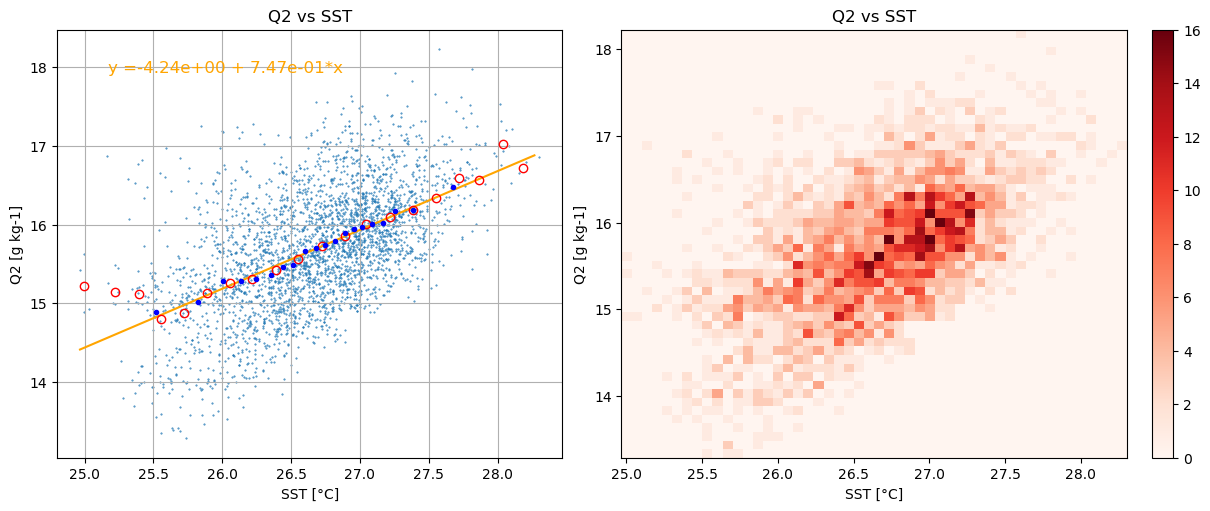

In [25]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "Q2 vs SST"
xlabel = 'SST [°C]'; ylabel = "Q2 [g kg-1]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [26]:
# linear regression RH vs SST
x = sst_day[::nt,::nskip,::nskip].copy(); x = x-273.15
y = rh_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: PBLH vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: PBLH vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'RH [%]')

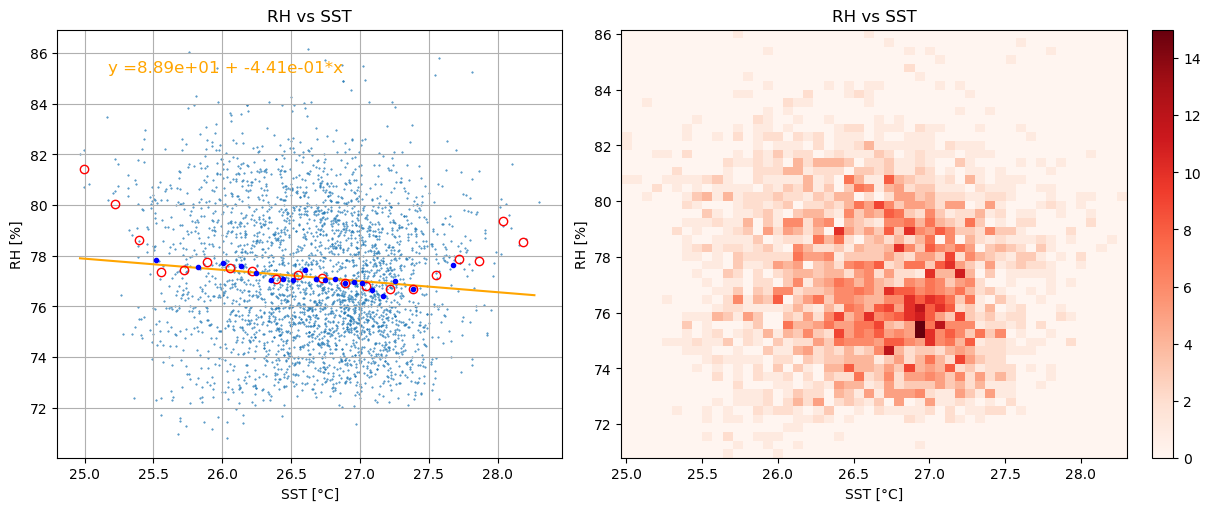

In [27]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "RH vs SST"
xlabel = 'SST [°C]'; ylabel = "RH [%]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [12]:
# linear regression PBLH vs SST
x = sst_day[::nt,::nskip,::nskip].copy(); x = x-273.15
y = PBLH_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: PBLH vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: PBLH vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'PBLH [m]')

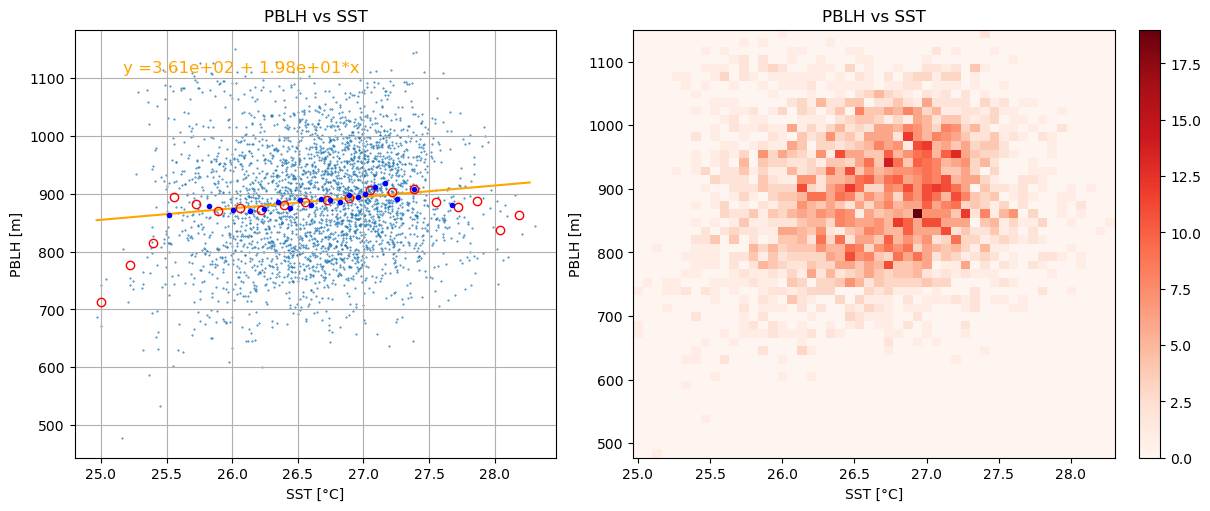

In [13]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "PBLH vs SST"
xlabel = 'SST [°C]'; ylabel = "PBLH [m]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [14]:
# linear regression LCL vs SST
x = sst_day[::nt,::nskip,::nskip].copy(); x = x-273.15
y = LCL_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: PBLH vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: PBLH vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'LCL [m]')

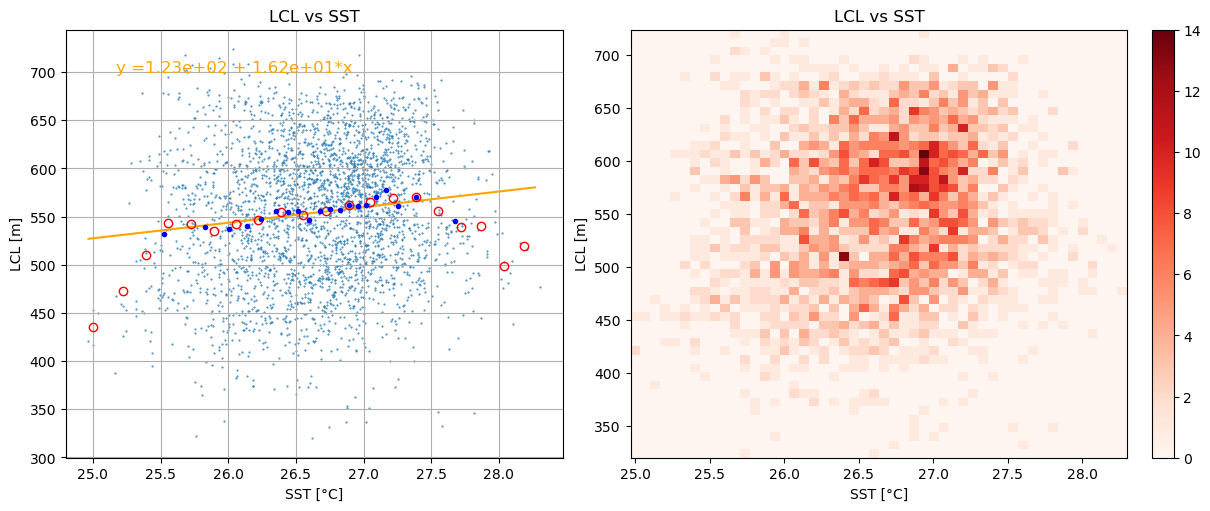

In [15]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "LCL vs SST"
xlabel = 'SST [°C]'; ylabel = "LCL [m]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [16]:
# linear regression U10 vs SST
x = sst_day[::nt,::nskip,::nskip].copy(); x = x-273.15
y = U_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: PBLH vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: PBLH vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'U [m s-1]')

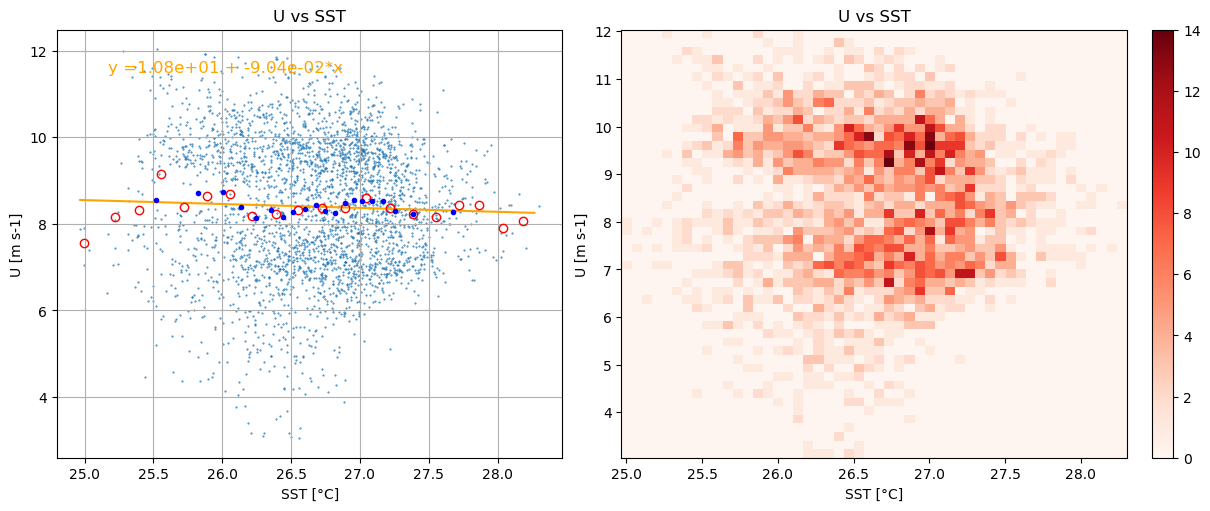

In [17]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "U vs SST"
xlabel = 'SST [°C]'; ylabel = "U [m s-1]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [18]:
# linear regression LHF vs SST
x = sst_day[::nt,::nskip,::nskip].copy(); x = x-273.15
y = LHF_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: LHF vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: LHF vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'LHF [W m-2]')

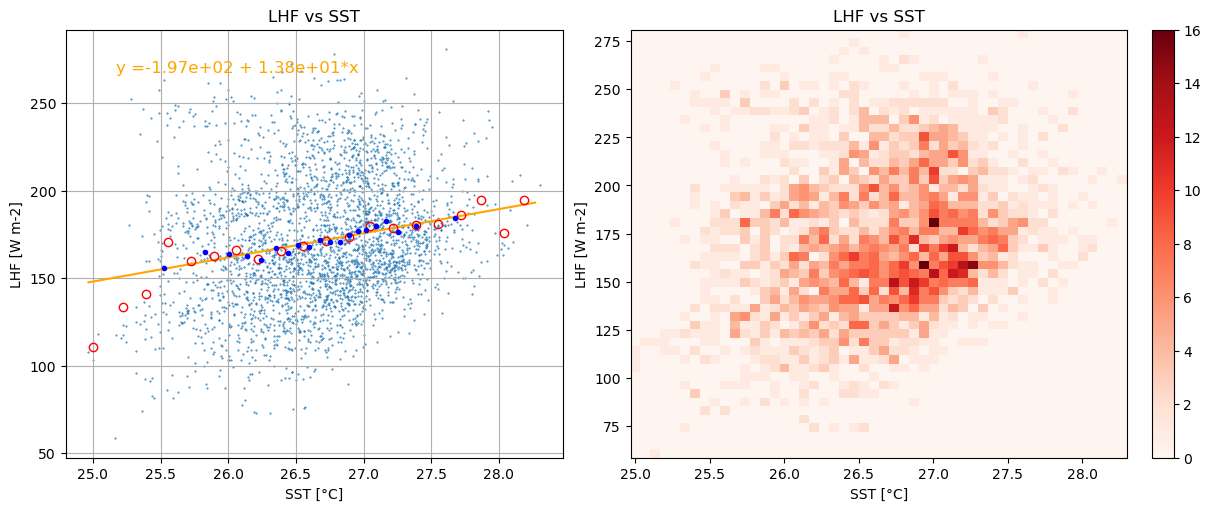

In [19]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "LHF vs SST"
xlabel = 'SST [°C]'; ylabel = "LHF [W m-2]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [20]:
# linear regression SHF vs SST
x = sst_day[::nt,::nskip,::nskip].copy(); x = x-273.15
y = SHF_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: LHF vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: LHF vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'SHF [W m-2]')

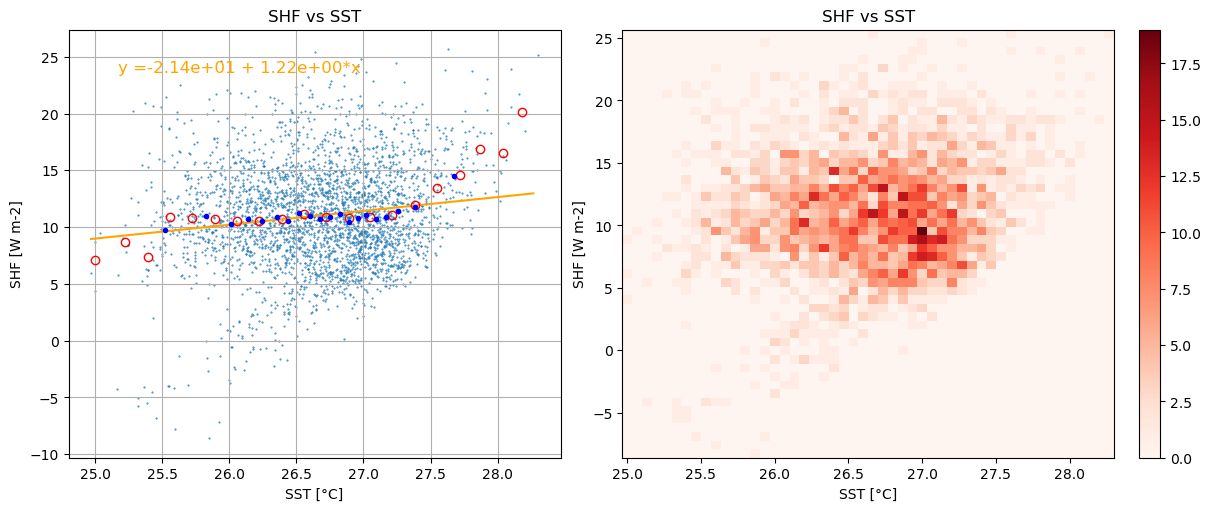

In [21]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "SHF vs SST"
xlabel = 'SST [°C]'; ylabel = "SHF [W m-2]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [ ]:
############
# ANOMALIES
############

In [11]:
# SCATTERPLOT + DISTRIBUTION
# corr length
L = 30
nskip = int(L/3)
nt = int(1)
nbin_hist = 50
# distribution
thrsld_n = 100
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [11]:
# linear regression dT2 vs dSST
x = dsst_day[::nt,::nskip,::nskip].copy()
y = dt2_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

x = dsst_day.copy()
y = dt2_day.copy()
control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: PBLH vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: PBLH vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

In [15]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
np.savetxt(path_bindist + 'pdist_dT2_dsst_day.txt', pdist_variable)
np.savetxt(path_bindist + 'pstd_dT2_dsst_day.txt', pstd_variable)
np.savetxt(path_bindist + 'pstderr_dT2_dsst_day.txt', pstd_err_variable)

Text(0, 0.5, 'T2 anomalies [°C]')

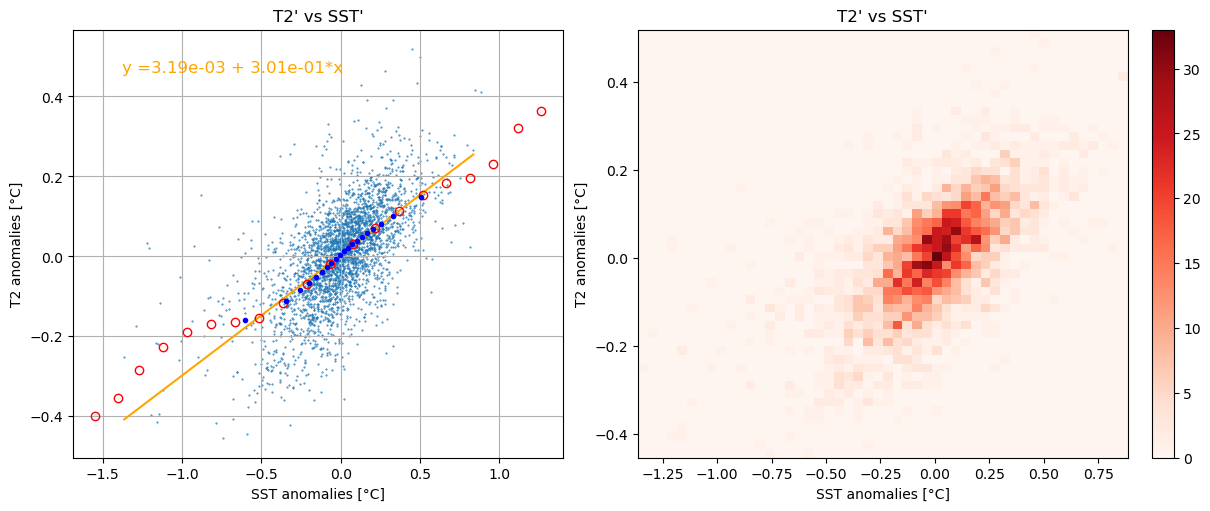

In [20]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

x = dsst_day[::nt,::nskip,::nskip].copy()
y = dt2_day[::nt,::nskip,::nskip].copy()

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "T2' vs SST'"
xlabel = 'SST anomalies [°C]'; ylabel = "T2 anomalies [°C]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [12]:
# linear regression dQ2 vs dSST
x = dsst_day[::nt,::nskip,::nskip].copy()
y = dq2_day[::nt,::nskip,::nskip].copy(); y = y*1000.
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

x = dsst_day[:,::nskip,::nskip].copy()
y = dq2_day[:,::nskip,::nskip].copy(); y = y*1000.
control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: PBLH vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: PBLH vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

In [15]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/anomalies/'
np.savetxt(path_bindist + 'pdist_dQ2_dsst_day_Lcorr30km.txt', pdist_variable)
np.savetxt(path_bindist + 'pstd_dQ2_dsst_day_Lcorr30km.txt', pstd_variable)
np.savetxt(path_bindist + 'pstderr_dQ2_dsst_day_Lcorr30km.txt', pstd_err_variable)

Text(0, 0.5, 'Q2 anomalies [g kg-1]')

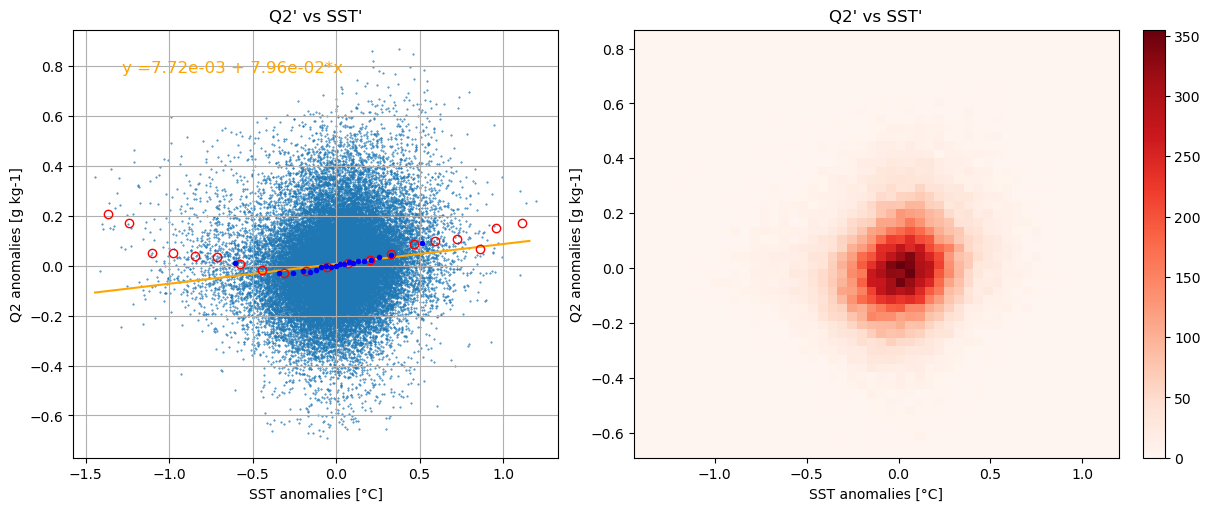

In [13]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

x = dsst_day[::nt,::nskip,::nskip].copy()
y = dq2_day[::nt,::nskip,::nskip].copy(); y = y*1000.

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "Q2' vs SST'"
xlabel = 'SST anomalies [°C]'; ylabel = "Q2 anomalies [g kg-1]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [30]:
# linear regression dRH vs dSST
x = dsst_day[::nt,::nskip,::nskip].copy()
y = drh_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: PBLH vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: PBLH vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'RH anomalies [%]')

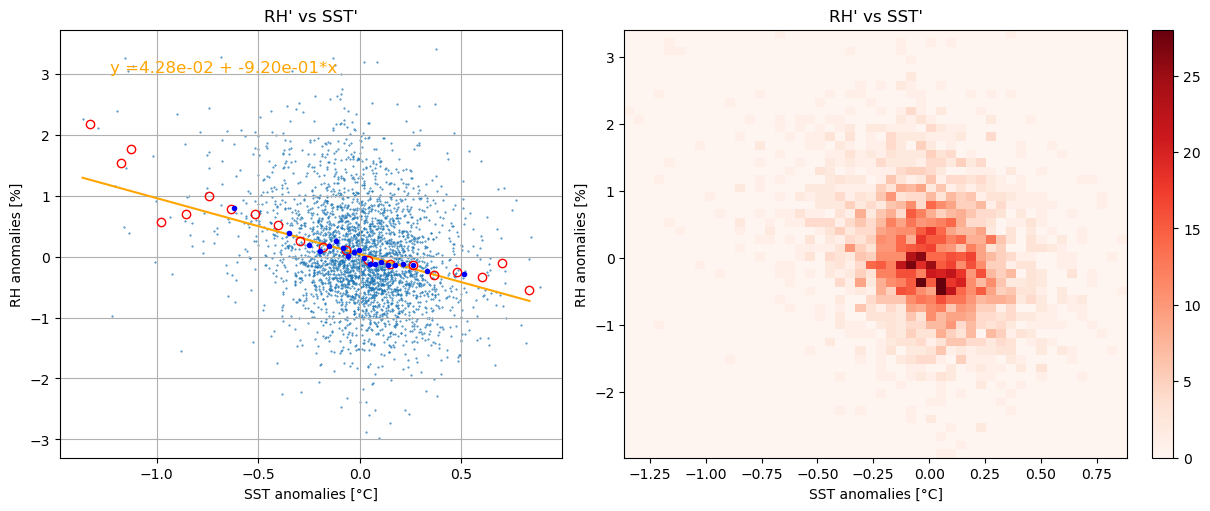

In [31]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "RH' vs SST'"
xlabel = 'SST anomalies [°C]'; ylabel = "RH anomalies [%]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [15]:
# linear regression dPBLH vs dSST
x = dsst_day[::nt,::nskip,::nskip].copy()
y = dPBLH_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

x = dsst_day.copy()
y = dPBLH_day.copy()
control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: PBLH vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: PBLH vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'PBLH anomalies [m]')

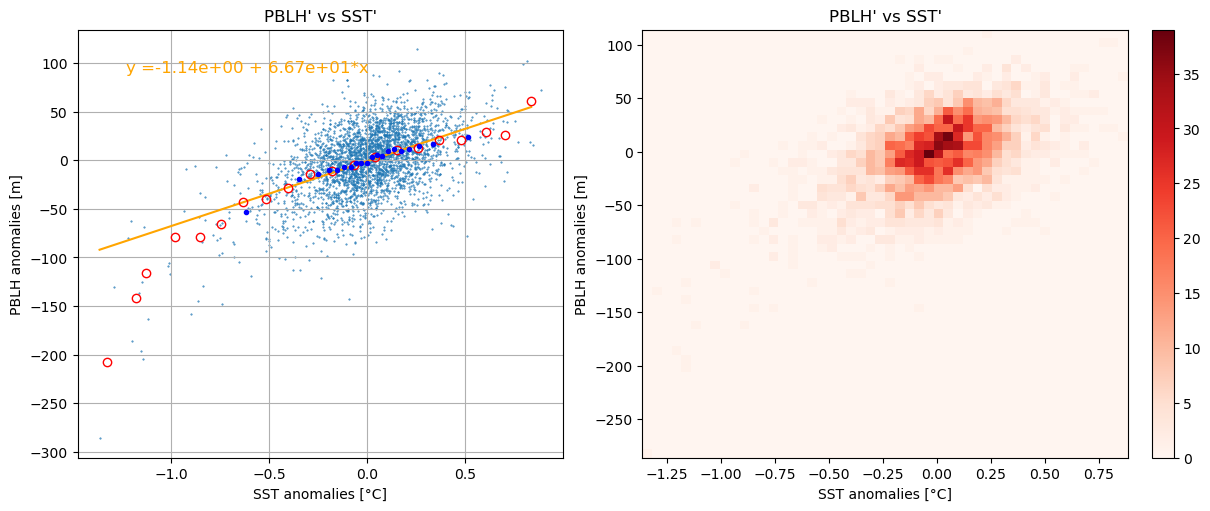

In [33]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "PBLH' vs SST'"
xlabel = 'SST anomalies [°C]'; ylabel = "PBLH anomalies [m]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [17]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/anomalies/'
np.savetxt(path_bindist + 'pdist_dPBLH_dsst_day.txt', pdist_variable)
np.savetxt(path_bindist + 'pstd_dPBLH_dsst_day.txt', pstd_variable)
np.savetxt(path_bindist + 'pstderr_dPBLH_dsst_day.txt', pstd_err_variable)

In [18]:
# linear regression dLCL vs dSST
x = dsst_day[::nt,::nskip,::nskip].copy()
y = dLCL_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

x = dsst_day.copy()
y = dLCL_day.copy()
control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: PBLH vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: PBLH vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'LCL anomalies [m]')

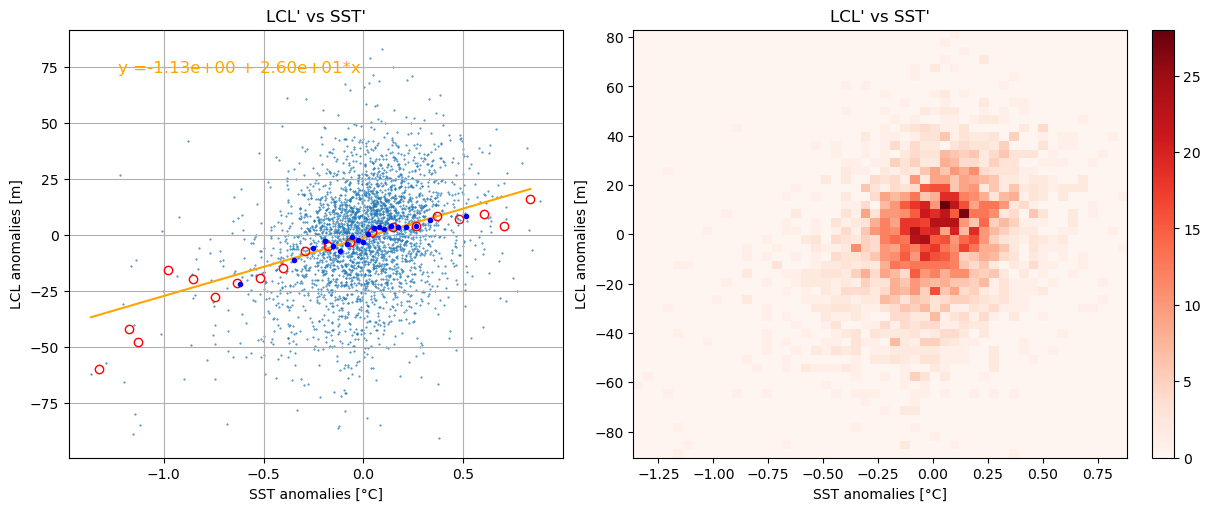

In [35]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "LCL' vs SST'"
xlabel = 'SST anomalies [°C]'; ylabel = "LCL anomalies [m]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [19]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/anomalies/'
np.savetxt(path_bindist + 'pdist_dLCL_dsst_day.txt', pdist_variable)
np.savetxt(path_bindist + 'pstd_dLCL_dsst_day.txt', pstd_variable)
np.savetxt(path_bindist + 'pstderr_dLCL_dsst_day.txt', pstd_err_variable)

In [36]:
# linear regression dU10 vs dSST
x = dsst_day[::nt,::nskip,::nskip].copy()
y = dU_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: PBLH vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: PBLH vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'U anomalies [m s-1]')

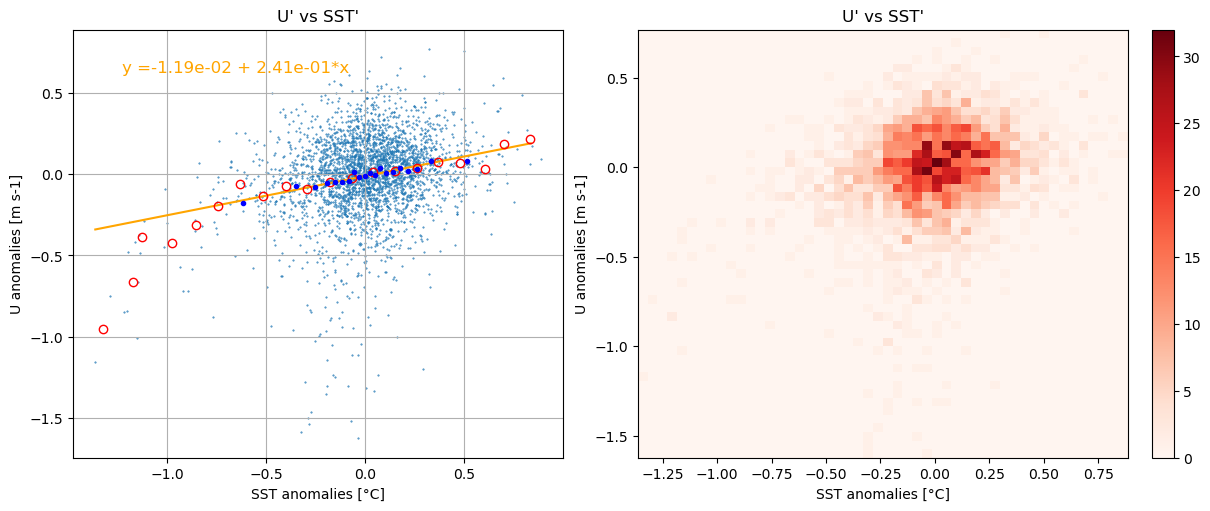

In [37]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "U' vs SST'"
xlabel = 'SST anomalies [°C]'; ylabel = "U anomalies [m s-1]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [38]:
# linear regression dLHF vs dSST
x = dsst_day[::nt,::nskip,::nskip].copy()
y = dLHF_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: LHF vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: LHF vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'LHF anomalies [W m-2]')

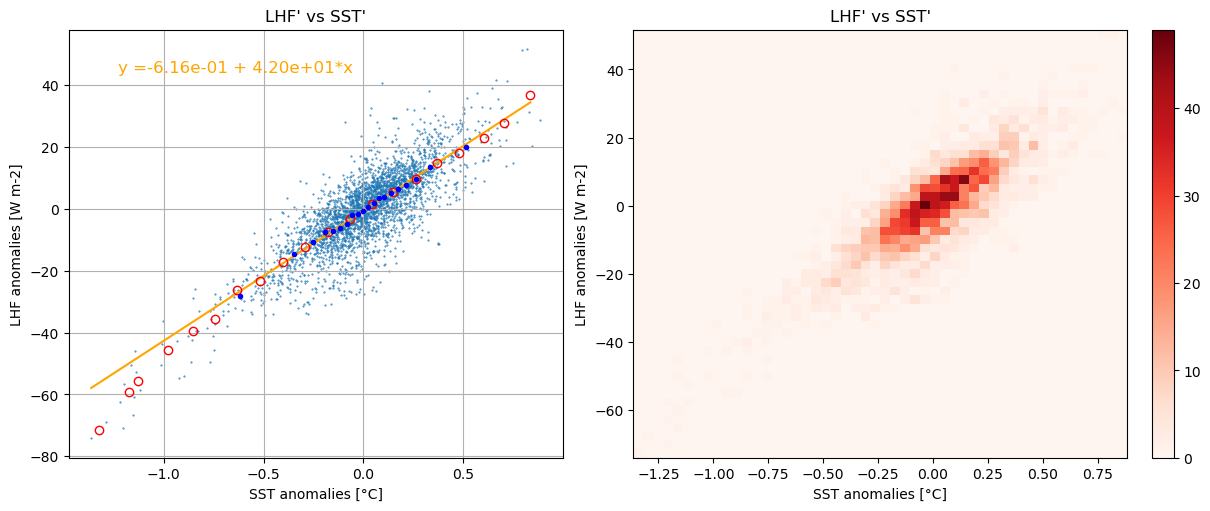

In [39]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "LHF' vs SST'"
xlabel = 'SST anomalies [°C]'; ylabel = "LHF anomalies [W m-2]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [40]:
# linear regression dSHF vs dSST
x = dsst_day[::nt,::nskip,::nskip].copy()
y = dSHF_day[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: LHF vs SST
pdist_control, pdist_variable, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: LHF vs SST
dist_control, dist_variable, std_err_variable, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, thrsld_n, perc_step)

Text(0, 0.5, 'SHF anomalies [W m-2]')

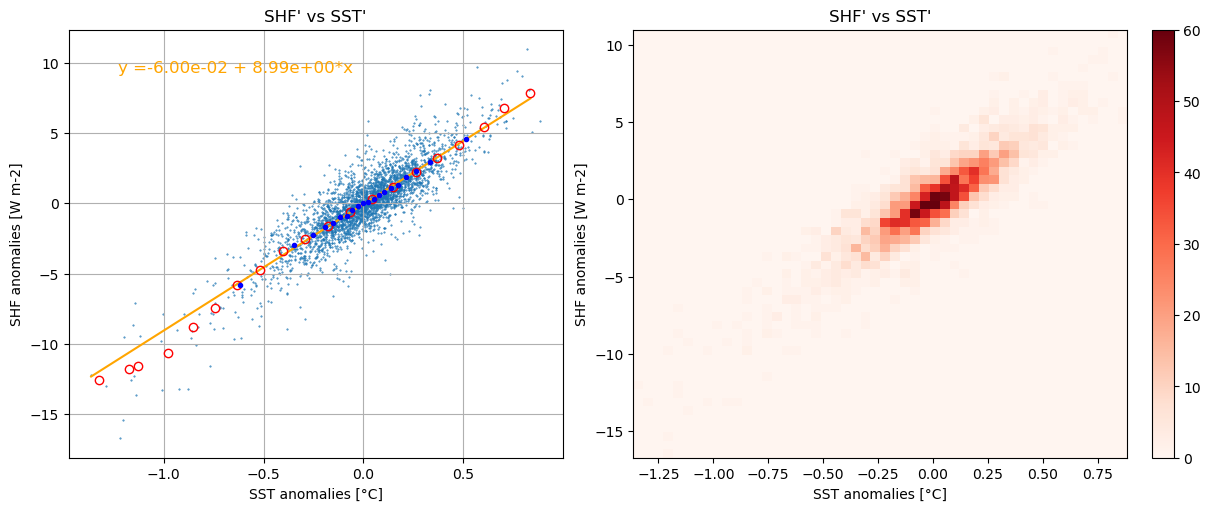

In [41]:
# FIGURE
fig = plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
# scatterplot lin regression 
title = "SHF' vs SST'"
xlabel = 'SST anomalies [°C]'; ylabel = "SHF anomalies [W m-2]"
xa = np.arange(np.nanmin(x),np.nanmax(x),0.1)
plt.scatter(x, y, s=0.2)
plt.plot(xa, linreg_res.slope*xa + linreg_res.intercept, color='orange')
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)
ff2 = "{:.2e}".format
plt.annotate('y =' + str(ff2(linreg_res.intercept)) + ' + ' + str(ff2(linreg_res.slope)) + '*x', xy=(0.1, 0.9), \
             xycoords='axes fraction', fontsize=12, color='orange')
plt.grid()

plt.plot(dist_control, dist_variable, 'o', color='r', mfc='none')
plt.plot(pdist_control, pdist_variable, '.',color='b')

# histogram 2d 
plt.subplot(1,2,2)    
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
H, xedges, yedges = np.histogram2d(x,y, bins=nbin_hist)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, cmap='Reds')
plt.colorbar()
plt.title(title, fontsize=12)
plt.xlabel(xlabel); plt.ylabel(ylabel)

In [7]:
# daily varaibles
# select sst, U, PBLH
sst_day = ds['SST'].groupby('XTIME.day').mean().values*seamask
q2_day = ds['Q2'].groupby('XTIME.day').mean().values*seamask

In [16]:
# read QVAPOR DAY
path_dir = '/media/fabien/DAGOBAH/WRF_EUREC4A/CNT/FEB/01_var_33levels/'
ds_tmp = xr.open_dataset(path_dir + 'QVAPOR_d02_2020-02')
maskl_lon = (ds_tmp.XLONG >= minlon) & (ds_tmp.XLONG <= maxlon)
maskl_lat = (ds_tmp.XLAT >= minlat) & (ds_tmp.XLAT <= maxlat)
ds_tmp = ds_tmp.where(maskl_lon & maskl_lat, drop=True)
QVAPOR_day = ds_tmp['QVAPOR'][:,25].groupby('XTIME.day').mean().values*seamask
del ds_tmp

In [17]:
# compute anomalies daily data
s = 50
dsst_day = np.zeros(sst_day.shape); dq2_day = np.zeros(q2_day.shape)
dQVAPOR_day = np.zeros(QVAPOR_day.shape)
for t in range(0,QVAPOR_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)*seamask
    dsst_day[t] = sst_day[t] - sst_ave
    q2_ave = gm.nan_gaussian_filter(q2_day[t],s)*seamask
    dq2_day[t] = q2_day[t] - q2_ave
    q_ave = gm.nan_gaussian_filter(QVAPOR_day[t],s)*seamask
    dQVAPOR_day[t] = QVAPOR_day[t] - q_ave

0
10
20


In [18]:
# linear regression dQ2 vs dSST
nbins = 20; perc_step = 5
x = dsst_day.copy()
y = dq2_day.copy(); y = y*1000.
control = x.reshape(-1)
variable = y.reshape(-1)
##### Perc distribution: dQ2 vs dSST
pdist_control, pdist_dq2, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)
y = dQVAPOR_day.copy(); y = y*1000.
variable = y.reshape(-1)
##### Perc distribution: dQVAPOR vs dSST
pdist_control, pdist_dqvapor, pstd_variable, pstd_err_variable = perc_distribution(control, variable, nbins, perc_step)

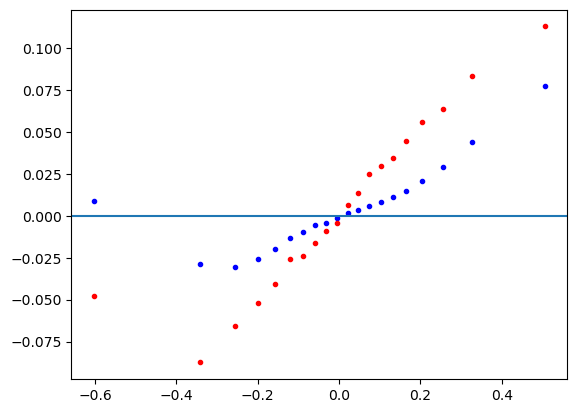

In [19]:
# FIGURE
plt.plot(pdist_control, pdist_dq2, '.',color='b')
plt.plot(pdist_control, pdist_dqvapor, '.',color='r')
plt.axhline(0)